# Уменьшение количества цветов изображения 

###### Импорт необходимых библиотек 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage import img_as_float
from sklearn.cluster import KMeans

###### Загрузка и преобразование изображения

In [2]:
parrots = imread('parrots.jpg')
# Число пикселей и цветовая схема изображения
parrots.shape

(474, 713, 3)

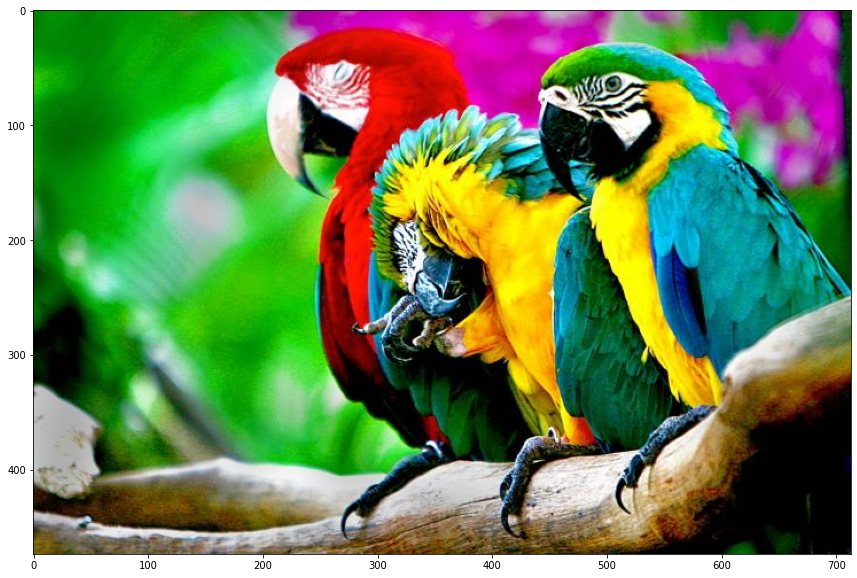

In [3]:
plt.figure(figsize=(20,10))
plt.imshow(parrots)
plt.show()

In [4]:
parrots = img_as_float(parrots)
parrots.shape
width = parrots.shape[1]
height = parrots.shape[0]

In [5]:
# Преобразование трехмерного массива пикселей изображения в двухмерный массив
parrots_matrix = parrots.reshape(-1, 3)
parrots_matrix.shape

(337962, 3)

In [6]:
parrots_matrix[0,:]

array([0.01568627, 0.49411765, 0.01960784])

###### Использование алгоритма K-means для кластеризации пикселей

In [7]:
# инициализация алгоритма кластеризации
k_means = KMeans(n_clusters=8, init='k-means++', random_state=241)

In [8]:
# процесс кластеризации
clusters = k_means.fit_predict(parrots_matrix)

In [9]:
print(f'Создано {len(np.unique(clusters))} кластеров')

Создано 8 кластеров


In [10]:
# заполнение пикселей каждого кластера средним и медианным значениями кластера
def clusterization(image_matrix, clusters):
    parr_clusterized = pd.DataFrame(np.hstack((parrots_matrix, np.expand_dims(clusters, axis=1))))
    parr_clusterized.rename({3: 'cluster'}, axis=1, inplace=True)

    parr_clusterized_mean = parr_clusterized.copy()
    parr_clusterized_median = parr_clusterized.copy()

    parr_clusterized_mean_grouped = parr_clusterized.groupby('cluster').mean()
    parr_clusterized_median_grouped = parr_clusterized.groupby('cluster').median()

    for cluster in range(len(np.unique(clusters))):
        parr_clusterized_mean.loc[parr_clusterized_mean['cluster'] == cluster, 
                                  [0, 1, 2]] = parr_clusterized_mean_grouped.loc[cluster].tolist()
        parr_clusterized_median.loc[parr_clusterized_median['cluster'] == cluster,
                                   [0, 1, 2]] = parr_clusterized_median_grouped.loc[cluster].tolist()
    
    return parr_clusterized_mean_grouped, parr_clusterized_median_grouped, parr_clusterized_mean, parr_clusterized_median

In [11]:
parr_clusterized_mean_grouped_8, parr_clusterized_median_grouped_8, parr_clusterized_mean_8, \
    parr_clusterized_median_8 = clusterization(parrots_matrix, clusters)

###### Оценка качества кластеризации с использованием PSNR

In [12]:
# создание функции метрики PSNR, которая будет использоваться для оценки качества кластеризации
def PSNR(true_image, noisy_image, width, height):
    noisy_image = noisy_image.to_numpy()
    summa = 0
    for i in range(true_image.shape[0]):
        for index, color in enumerate(true_image[i,:]):
            summa += (color - noisy_image[i,index]) ** 2
    mse = summa / (true_image.shape[0] * 3)
    max_i = 1
    return 20 * np.log10(max_i / np.sqrt(mse))

In [13]:
parr_clusterized_mean_8 = parr_clusterized_mean_8.drop(columns=['cluster'], axis=1)
parr_clusterized_median_8 = parr_clusterized_median_8.drop(columns=['cluster'], axis=1)

In [14]:
# оценка качества для изображения, аппроксимированного по 8 кластерам
print('Оценка качества при уменьшении количества цветов до 8 со средними значениями:', 
      round(PSNR(parrots_matrix, parr_clusterized_mean_8, width, height)))
print('Оценка качества при уменьшении количества цветов до 8 с медианными значениями:', 
      round(PSNR(parrots_matrix, parr_clusterized_median_8, width, height)))

Оценка качества при уменьшении количества цветов до 8 со средними значениями: 18
Оценка качества при уменьшении количества цветов до 8 с медианными значениями: 18


In [15]:
# изменение оценки качества при увеличении количества кластеров:
PSNR_scores_mean = []
PSNR_scores_median = []
for n in range(8, 14):
    k_means_new = KMeans(n_clusters=n, init='k-means++', random_state=241)
    clusters = k_means_new.fit_predict(parrots_matrix)
    
    grouped_by_mean, grouped_by_median, mean_n, median_n = clusterization(parrots_matrix, clusters)
    mean_n = mean_n.drop(columns=['cluster'], axis=1)
    median_n = median_n.drop(columns=['cluster'], axis=1)
    
    score_mean = PSNR(parrots_matrix, mean_n, width, height)
    score_median = PSNR(parrots_matrix, median_n, width, height)
    PSNR_scores_mean.append(score_mean)
    PSNR_scores_median.append(score_median)
    print(f'Оценка качества при уменьшении количества цветов до {n} со средними значениями:', 
      round(score_mean, 2))
    print(f'Оценка качества при уменьшении количества цветов до {n} с медианными значениями:', 
      round(score_median, 2))

Оценка качества при уменьшении количества цветов до 8 со средними значениями: 18.47
Оценка качества при уменьшении количества цветов до 8 с медианными значениями: 18.18
Оценка качества при уменьшении количества цветов до 9 со средними значениями: 19.14
Оценка качества при уменьшении количества цветов до 9 с медианными значениями: 18.85
Оценка качества при уменьшении количества цветов до 10 со средними значениями: 19.68
Оценка качества при уменьшении количества цветов до 10 с медианными значениями: 19.45
Оценка качества при уменьшении количества цветов до 11 со средними значениями: 20.16
Оценка качества при уменьшении количества цветов до 11 с медианными значениями: 19.9
Оценка качества при уменьшении количества цветов до 12 со средними значениями: 20.63
Оценка качества при уменьшении количества цветов до 12 с медианными значениями: 20.34
Оценка качества при уменьшении количества цветов до 13 со средними значениями: 21.06
Оценка качества при уменьшении количества цветов до 13 с медианны

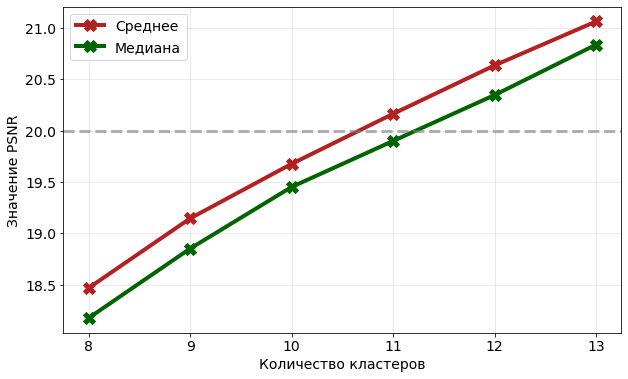

In [16]:
plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': 14})
plt.plot(np.arange(8, 14), PSNR_scores_mean, lw=4.0, color='firebrick', marker='X', ms=12.0)
plt.plot(np.arange(8, 14), PSNR_scores_median, lw=4.0, color='darkgreen', marker='X', ms=12.0)
plt.axhline(y=20, linestyle='dashed', lw=3.0, color='grey', alpha=0.6)
plt.xlabel('Количество кластеров')
plt.ylabel('Значение PSNR')
plt.legend(['Среднее', 'Медиана'])
plt.grid(alpha=0.3)
plt.show()

Таким образом, при кластеризации на 11 отдельных групп оценка качества достигает значения выше 20 именно в том случае, если использовать средние значения по кластеру. Также по графику видно, что использование медианных значений для заполнения пикселей в том или ином кластере дает меньшее значение PSNR.

###### Визуализация кластеризованных изображений 

In [17]:
def recreate_image(target_colors, labels, width, height):
    return target_colors[labels].reshape(width, height, -1)

In [18]:
grouped_by_pixels = []
clusters_n = []
for n in np.arange(2, 23, 6):
    k_means_new = KMeans(n_clusters=n, init='k-means++', random_state=241)
    clusters = k_means_new.fit_predict(parrots_matrix)
    clusters_n.append(clusters)
    
    grouped_by_mean, grouped_by_median, mean_n, median_n = clusterization(parrots_matrix, clusters)
    grouped_by_pixels.append(grouped_by_mean)

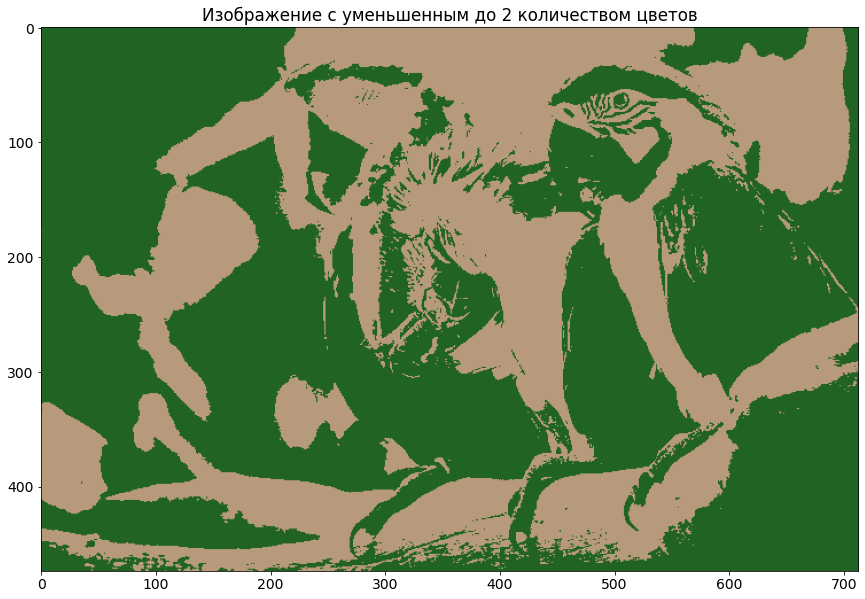

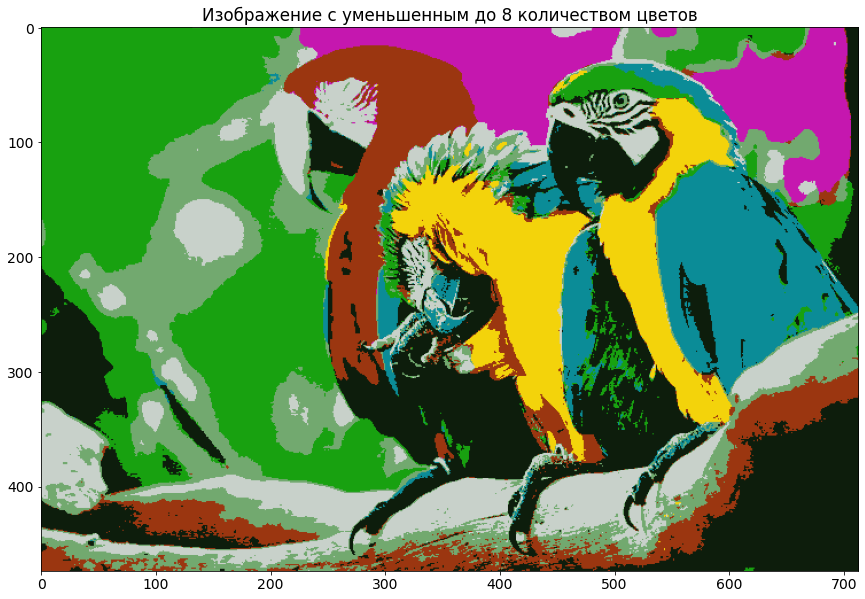

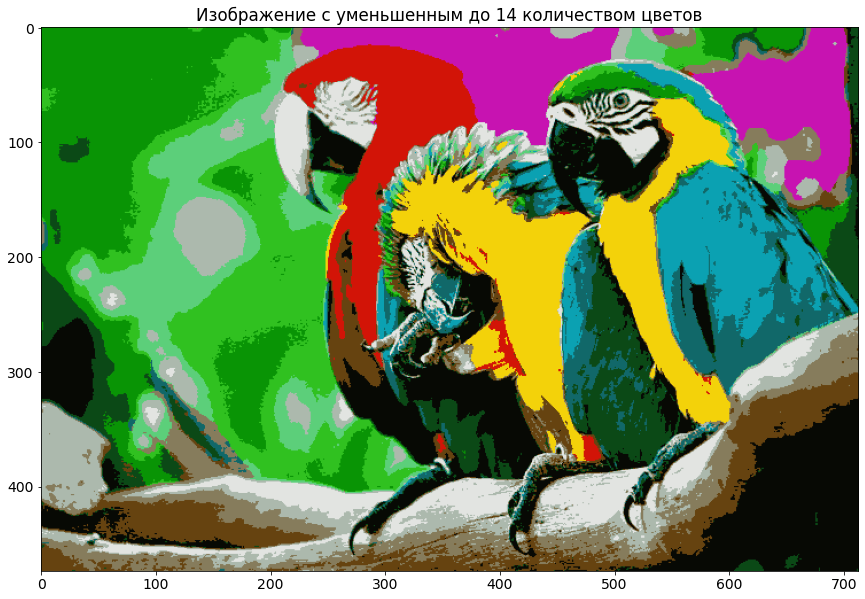

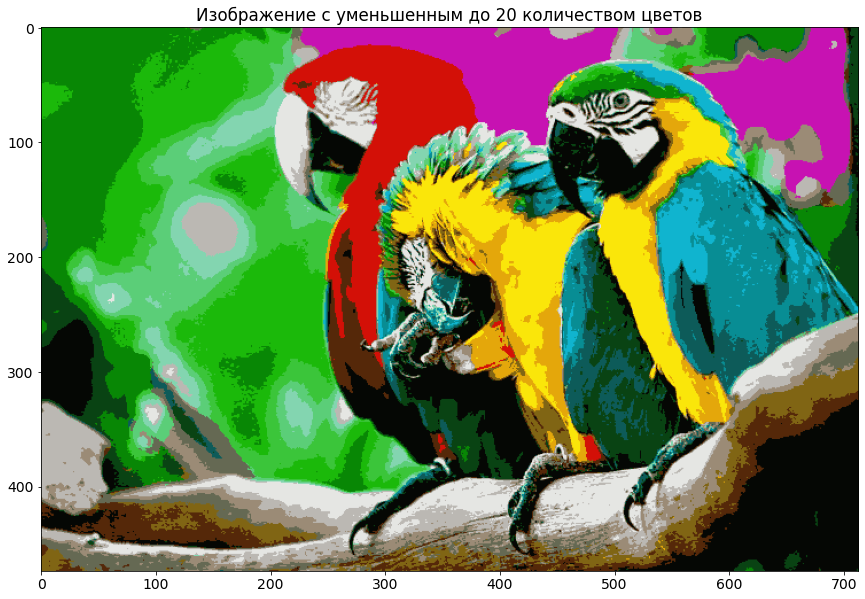

In [19]:
ar = np.arange(2, 23, 6)
for i in range(len(grouped_by_pixels)):
    plt.figure(figsize=(20,10))
    plt.imshow(recreate_image(grouped_by_pixels[i].to_numpy(), clusters_n[i], 474, 713))
    plt.title(f'Изображение с уменьшенным до {ar[i]} количеством цветов')
    plt.show()

Как видно из полученных изображений, уже при 8 цветах можно достаточно хорошо различить формы попугаев. Однако, фон, как и детали попугаев, все еще лишены глубины, которая повышается с увеличением кластеров (цветов).